## Simulation of Gaussian beam incident on dual microlens arrays (MLA's) for laser beam array generation.

In [1]:
%pylab
%matplotlib inline
import SimMLA.fftpack as simfft
import SimMLA.grids   as grids
import SimMLA.fields  as fields

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


After simulating plane wave incidence on the MLA's, the next step in the development of the simulations is to simulate a real beam incident on the MLA's. A natural choice for doing so is a Gaussian beam. We will use the `fields` library in SimMLA to generate 1D Gaussian beams for propagation through the MLA setup.

First, let's start by setting up our MLA illuminator as before.

In [3]:
numLenslets = 21    # Must be odd; corresponds to the number of lenslets in one dimension
lensletSize = 500   # microns
focalLength = 13700 # microns

wavelength  = 0.642 # microns

subgridSize  = 1001                     # Number of grid (or lattice) sites for a single lenslet
physicalSize = numLenslets * lensletSize # The full extent of the MLA

# dim = 1 makes the grid 1D
grid = grids.GridArray(numLenslets, subgridSize, physicalSize, wavelength, focalLength, dim = 1, zeroPad = 3)

Propagate the field through the MLA and find the average irradiance.

In [4]:
Z0       = 376.73 # Impedance of free space, Ohms
power    = 100  # mW
beamStd  = 1000 # microns

# Collimating lens
fc = 50000 # microns

# Diffuser properties
grainSize = 40   # microns
beamSize  = 1000 # microns
powerScat = 0.99  # fraction of power scattered by diffuser

fieldAmp = np.sqrt(power / 1000 * Z0 / beamStd / np.sqrt(np.pi)) # Factor of 1000 converts from mW to W
beam     = fields.GaussianWithDiffuser(fieldAmp,
                                       beamStd,
                                       physicalSize, # MLA aperture size, not grid size
                                       powerScat  = powerScat,
                                       wavelength = wavelength,
                                       fc         = fc,
                                       grainSize  = grainSize,
                                       beamSize   = beamSize)

fObj         = 3300   # microns
propDistance = 200000 # microns
bfpDiam      = 2 * 1.4 * fObj # BFP diameter, 2 * NA * f_OBJ

# Grid for interpolating the field after the second MLA
newGridSize = subgridSize * numLenslets # meters
newGrid     = grids.Grid(5*newGridSize, 5*physicalSize, wavelength, fObj, dim = 1)

In [6]:
%%time
nIter = 25

avgIrrad = np.zeros(newGrid.px.size, dtype=np.float128)
for realization in range(nIter):

    # Field propagation
    # Compute the interpolated fields
    interpMag, interpPhase = simfft.fftSubgrid(beam, grid)

    field   = np.zeros(newGrid.gridSize)

    # For each interpolated magnitude and phase corresponding to a lenslet
    # 1) Compute the full complex field
    # 2) Sum it with the other complex fields
    for currMag, currPhase in zip(interpMag, interpPhase):
        fieldMag   = currMag(newGrid.px)
        fieldPhase = currPhase(newGrid.px)

        currField = fieldMag * np.exp(1j * fieldPhase)
        field     = field + currField
        
    # Propagate new field to the objective back aperture and clip the results
    u2 = simfft.fftPropagate(field, newGrid, propDistance)
    u2Prime = u2.copy() # Important to copy, otherwise u2Prime and u2 are the same array in memory!
    u2Prime[np.logical_or(newGrid.px < -bfpDiam / 2, newGrid.px > bfpDiam / 2)] = 0.0
    
    # Propagate the field in the BFP to the sample
    scalingFactor = newGrid.physicalSize / (newGrid.gridSize - 1) / np.sqrt(newGrid.wavelength * newGrid.focalLength)
    F             = scalingFactor * np.fft.fftshift(np.fft.fft(np.fft.ifftshift(u2Prime)))    
        
    # Compute the irradiance on the sample
    Irrad = np.abs(F)**2 / Z0 * 1000
    
    # Save the results for this realization
    avgIrrad = avgIrrad + Irrad
    
# Average irradiance
avgIrrad = avgIrrad / nIter

CPU times: user 5min 35s, sys: 976 ms, total: 5min 36s
Wall time: 5min 36s


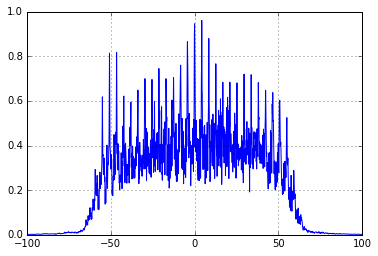

In [9]:
plt.plot(newGrid.pX, avgIrrad)
plt.xlim((-100,100))
plt.grid(True)
plt.show()